In [91]:
from pathlib import Path
from random import shuffle
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from src.storage.excel_cdi import get_cdi_data
from src.storage.schema import cdi_schema, ipca_schema
from src.storage.excel_ipca import get_ipca_data
from src.config import pr_root

###### Esse notebook é de um projeto ainda em desenvolvimento. Ele é atualizado uma vez antes de cada release. Se você clonou o repositório a partir do commit mais recente, algumas informações podem estar desatualizadas. ######

# 2. Visualizações

Agora, como podemos trabalhar com esses dados?
Vamos começar com uma visualização simples da taxa mensal do CDI em 2024.

Primeiro, vamos pegar os dados do CDI para 2024 com essa função. Ela devolve os dados em um dataframe do pandas. Como já temos dados demonstrativos em notebooks/data, vamos utilizar o parâmetro data_dir carregar seus dados.

In [92]:
# Função em src/storage/cdi_excel.py
df_cdi = get_cdi_data(year=2024, data_dir=Path(pr_root / "notebooks/data"))

Agora, vamos separar as séries do dataframe.

In [93]:
cdi_dates = df_cdi['date']
cdi_monthly_rate_dec = df_cdi['cdi_monthly_rate']

Por conveniência, vamos criar uma série só com os meses, para usar no eixo x do gráfico.


In [94]:
cdi_dates_copy = pd.to_datetime(df_cdi['date'], format='%Y-%m')
cdi_months = cdi_dates_copy.dt.month

Maravilha! Vamos usar o matplotlib e criar um gráfico simples.

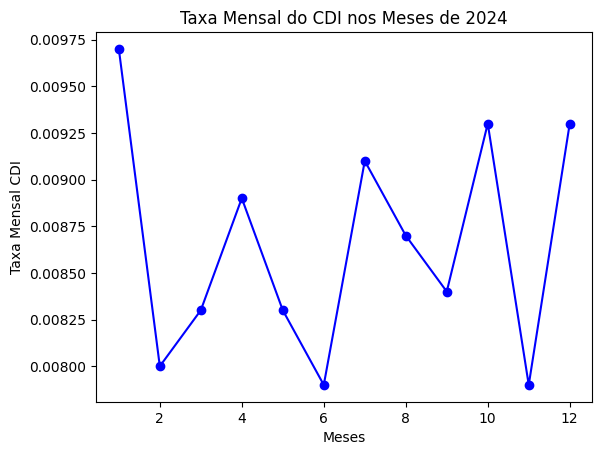

In [95]:
plt.plot(cdi_months, cdi_monthly_rate_dec, color='blue', marker='o', linestyle='solid')
plt.title('Taxa Mensal do CDI nos Meses de 2024')
plt.xlabel('Meses')
plt.ylabel('Taxa Mensal CDI')
plt.show()

Isso já é perfeitamente funcional. Ah, mas os dados não estão tão apresentáveis assim, né? Vamos dar um jeito nisso com algumas transformações simples.

Primeiro, vamos converter a taxa decimal em porcentagens.

In [96]:
cdi_monthly_rate_perc = [rate * 100 for rate in cdi_monthly_rate_dec]

Para auxiliar ainda mais na visualização. Vamos criar uma função de formatação.

In [97]:
def format_rate(x, pos):
    return f"{x:.1f}%".replace('.', ',')

Ela faz três coisas: Limita a taxa a uma casa decimal, adiciona o símbolo de porcentagem, e troca o ponto pela vírgula. Aplicaremos essa função ao plot quando renderizarmos ele de novo. Agora, vamos tratar o eixo x.

In [98]:
months_dict = {
    1: 'jan/24',
    2: 'fev/24',
    3: 'mar/24',
    4: 'abr/24',
    5: 'mai/24',
    6: 'jun/24',
    7: 'jul/24',
    8: 'ago/24',
    9: 'set/24',
    10: 'out/24',
    11: 'nov/24',
    12: 'dez/24'
}

cdi_months_formatted = cdi_months.map(months_dict)

Simplesmente mapeamos os números dos meses para strings, substituindo a série anterior. Agora, vamos criar o gráfico novamente. Aqui, utilizamos a função FuncFormatter para aplicar a formatação do eixo y.

```python
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rate))
```

Utilizamos essas funções para ajustar o eixo y do gráfico.
```python
plt.ylim(0, max(cdi_monthly_rate_perc) * 2.1)  # Reajusta os limites do eixo y, sem isso mudanças pequenas parecem como enormes
plt.grid(axis="y", linestyle="--", alpha=0.4)  # Adiciona uma grade horizontal
```

Finalmente, usamos essa função para evitar a sobreposição dos rótulos do eixo x.
```python
plt.xticks(rotation=45)
```

Juntando tudo, esse é o resultado final:

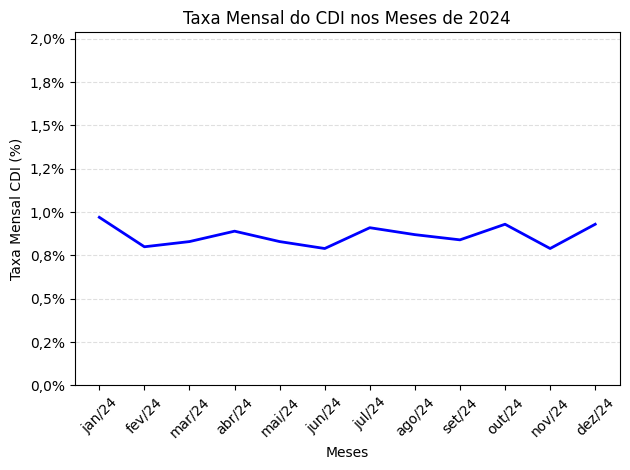

In [99]:
plt.plot(cdi_months_formatted, cdi_monthly_rate_perc, color='blue', linestyle='solid', linewidth=2)
plt.title('Taxa Mensal do CDI nos Meses de 2024')
plt.xlabel('Meses')
plt.ylabel('Taxa Mensal CDI (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rate))
plt.xticks(rotation=45)
plt.ylim(0, max(cdi_monthly_rate_perc) * 2.1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Perfeito. Eis, então, toda a lógica por trás da função implementada no projeto.

In [100]:
def add_line(ax, x_data, y_data, color, linestyle='solid', linewidth=2, **kwargs):
    ax.plot(x_data, y_data, color=color, linestyle=linestyle,
             linewidth=linewidth, **kwargs)


def setup_plot(ax, title, x_label, y_label, y_lim=None, add_grid=True, add_legend=False):
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.yaxis.set_major_formatter(FuncFormatter(format_rate))
    ax.tick_params(axis="x", rotation=45)

    if y_lim:
        ax.set_ylim(y_lim)

    if add_grid:
        ax.grid(axis="y", linestyle="--", alpha=0.4)

    if add_legend:
        ax.legend()

Uma função para adicionar linhas ao gráfico, e outra para configurar o gráfico como um todo.

Deixamos a função sem o plt.show() para permitir novos parâmetros antes da renderização final. Note, também, que para utilizar essas funções, é necessário criar um objeto de figura e eixo com plt.subplots().

In [101]:
%%capture
fig, ax1 = plt.subplots()

Também adicionamos essa função para tornar genérica a transformação das datas do eixo x.

In [102]:
def format_months(month_series, year_series=None):
    months_dict = {
        1: 'jan', 2: 'fev', 3: 'mar', 4: 'abr', 5: 'mai', 6: 'jun',
        7: 'jul', 8: 'ago', 9: 'set', 10: 'out', 11: 'nov', 12: 'dez'
    }

    formatted = month_series.map(months_dict)

    if year_series is not None:
        year_short = (year_series % 100).astype(str)
        formatted = formatted + '/' + year_short

    return formatted

Ela funciona mesmo se o gráfico for de múltiplos anos. E também permite que o ano seja opcional.

Agora, vamos demonstrar essas funções plottando os outros dados.

Para taxa anual do CDI em 2024:

In [103]:
cdi_annual_rate_dec = df_cdi['cdi_annual_rate']  # Reutilizamos o dataframe que a gente já pegou
cdi_annual_rate_perc = [rate * 100 for rate in cdi_annual_rate_dec]

add_line(ax1, cdi_months_formatted, cdi_annual_rate_perc, color='blue', linestyle='solid')

setup_plot(ax=ax1,
           title='Taxa Anual do CDI nos Meses de 2024',
           x_label='Meses',
           y_label='Taxa Anual CDI (%)',
           y_lim=(0, max(cdi_annual_rate_perc) * 2.1))

plt.show()

Para a taxa mensal do IPCA:

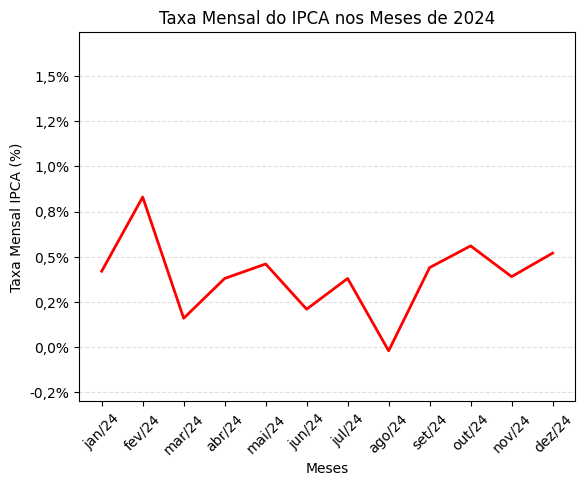

In [104]:
df_ipca = get_ipca_data(2024)

fig2, ax2 = plt.subplots()

ipca_dates_copy = pd.to_datetime(df_ipca['date'], format='%Y-%m')
ipca_months = ipca_dates_copy.dt.month
ipca_years = ipca_dates_copy.dt.year

ipca_months_formatted = format_months(ipca_months, ipca_years)

ipca_monthly_rate_dec = df_ipca['ipca_monthly_rate']
ipca_monthly_rate_perc = [rate * 100 for rate in ipca_monthly_rate_dec]

add_line(ax2, ipca_months_formatted, ipca_monthly_rate_perc, color='red', linestyle='solid')

setup_plot(ax=ax2,
           title='Taxa Mensal do IPCA nos Meses de 2024',
           x_label='Meses',
           y_label='Taxa Mensal IPCA (%)',
           y_lim=(-0.3, max(ipca_monthly_rate_perc) * 2.1))
# Em agosto de 2024, a taxa mensal do IPCA foi negativa, modificamos o eixo y para demonstrar isso.

plt.show()

Para finalizar, aqui está um gráfico comparado as taxas mensais do CDI de 2020 até 2025

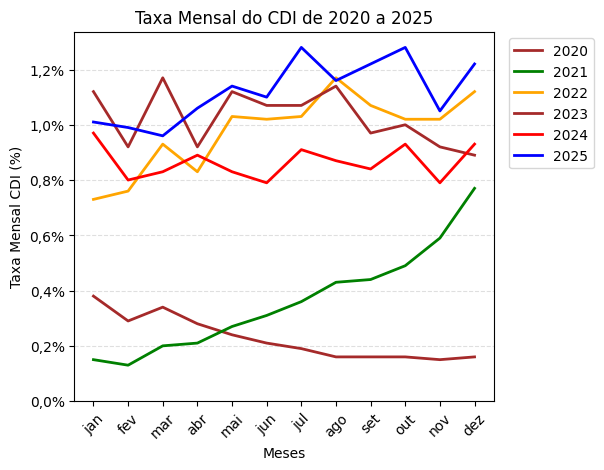

In [105]:
fig3, ax3 = plt.subplots()

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
shuffle(colors)
color_cycle = itertools.cycle(colors)

for year in [2020, 2021, 2022, 2023, 2024, 2025]:
    df_cdi_multi = get_cdi_data(year=year, data_dir=Path(pr_root / "notebooks/data"))

    cdi_dates_multi = pd.to_datetime(df_cdi_multi['date'], format='%Y-%m')
    month_positions = cdi_dates_multi.dt.month.values  # Convertendo para numpy array para evitar problemas de indexação

    cdi_monthly_rate_multi_perc = [rate * 100 for rate in df_cdi_multi['cdi_monthly_rate']]

    add_line(ax3, month_positions, cdi_monthly_rate_multi_perc,
             color=current_color,
             linestyle="solid",
             label=str(year))

    current_color = next(color_cycle)

setup_plot(ax=ax3,
           title='Taxa Mensal do CDI de 2020 a 2025',
           x_label='Meses',
           y_label='Taxa Mensal CDI (%)',
           y_lim=(0, None))

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.xticks(ticks=range(1, 13), labels=format_months(pd.Series(range(1, 13))), rotation=45)
plt.subplots_adjust(right=0.78)

plt.show()